# Imports

In [1]:
#General
import os as os
from os.path import join
from google.colab import drive
from PIL import Image
!pip install cairosvg
import cairosvg
import glob

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

# PyTorch components
import torchvision
from torchvision import datasets
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.3 MB/s eta 0:00:00


# Dataset initialization

## Target names and values creation

In [7]:
target_names=[
    #"E",      #empty cell, i don't want it since if the max prediction will be < threshold i'll predict E but i don't want to be able to directly predict the empty cell
    "WP","BP", #pawn
    "WN","BN", #knight
    "WB","BB", #bishop
    "WR","BR", #rook
    "WQ","BQ", #queen
    "WK","BK"  #king
]

target_values = [np.linspace(0,12,13)]

## Creating the .pgn from .svg files

Let's convert the .svg files to .png

In [ ]:
drive.mount('/content/gdrive')
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_PGN/Lichess_Piece_Sets"

for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  for image in os.listdir(specific_folder):
    name = image.split(sep=".")[0]
    # Convert SVG to PNG
    try:
      cairosvg.svg2png(url=specific_folder+image, write_to=specific_folder+name+'.png')
    except:
      ... #to be removed is interested in the prints
      #print(f"File: {name}.png already exists in folder: {folder}")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Then i need to delete the .svg files since i will not need them anymore

In [ ]:
drive.mount('/content/gdrive')
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_PGN/Lichess_Piece_Sets"
#specific pattern to eliminate
file_pattern = '*.svg'

for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  full_pattern = os.path.join(specific_folder, file_pattern)
  for svg in glob.glob(full_pattern):
    try:
        os.remove(svg)  # Delete the file
    except Exception as e:
        print(f"Error deleting {full_pattern}: {e}")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Changing .pgn backgrounds

I need to set different background colors for each of my .pgn in order to emulate the possible different Lichess boards and expose the model to not just the pieces shapes. I will need to create a lighter version, as well as a darker one, just like on the board.

In [2]:
color_scheme = [(218, 166, 113), #light brown
                (146, 116, 84),  #dark brown
                (214, 245, 255), #light cyan
                (153, 210, 229), #dark cyan
                (194, 255, 194), #light green
                (155, 217, 155), #dark green
                (222, 222, 222), #light grey
                (148, 148, 148), #dark grey
                (186, 156, 196), #light purple
                (164, 108, 183)  #dark purple
                ]

In [6]:
drive.mount('/content/gdrive')
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_PGN/Lichess_Piece_Sets"
cont = 0

for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  for image in os.listdir(specific_folder):
    # Open the existing PNG image
    im = Image.open(os.path.join(specific_folder,image))
    # Define the new background color (RGB format)
    for color in color_scheme:
      new_im = im.convert("RGBA")
      # Create a new image with the same size and the desired background color in RGB mode
      background = Image.new("RGB", im.size, color)
      # Paste the original image on top of the background, using its alpha channel as a mask
      background.paste(im, (0, 0), new_im)
      name = image.split(sep=".")[0]
      match name:
        case "bP" | "wP":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_PGN/Grouped_Pieces/0.Pawns/{name}{cont}.png")
        case "bN" | "wN":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_PGN/Grouped_Pieces/1.Knights/{name}{cont}.png")
        case "bB" | "wB":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_PGN/Grouped_Pieces/2.Bishops/{name}{cont}.png")
        case "bR" | "wR":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_PGN/Grouped_Pieces/3.Rooks/{name}{cont}.png")
        case "bQ" | "wQ":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_PGN/Grouped_Pieces/4.Queens/{name}{cont}.png")
        case "bK" | "wK":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_PGN/Grouped_Pieces/5.Kings/{name}{cont}.png")
      cont += 1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Checking the images dimension distribution

In [48]:
pieces = pd.DataFrame(columns=["Piece","Path","Dimension"])

drive.mount('/content/gdrive')
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_PGN/Grouped_Pieces/"

for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  for image in os.listdir(specific_folder):
    name = image.split(sep=".")[0]
    img = Image.open(os.path.join(specific_folder,image))
    width, height = img.size
    dimension = str(width) + "x" + str(height)

    if "P" in name: name = "Pawn"
    elif "N" in name: name = "Knight"
    elif "B" in name: name = "Bishop"
    elif "R" in name: name = "Rook"
    elif "Q" in name: name = "Queen"
    elif "K" in name: name = "King"

    pieces.loc[len(pieces)] = [name,os.path.join(specific_folder,image),dimension] #adding elements at the end of my DataFrame

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
pieces["Piece"] = pieces['Piece'].astype(str)
pieces["Path"] = pieces['Path'].astype(str)
pieces["Dimension"] = pieces['Dimension'].astype(str)

<Axes: >

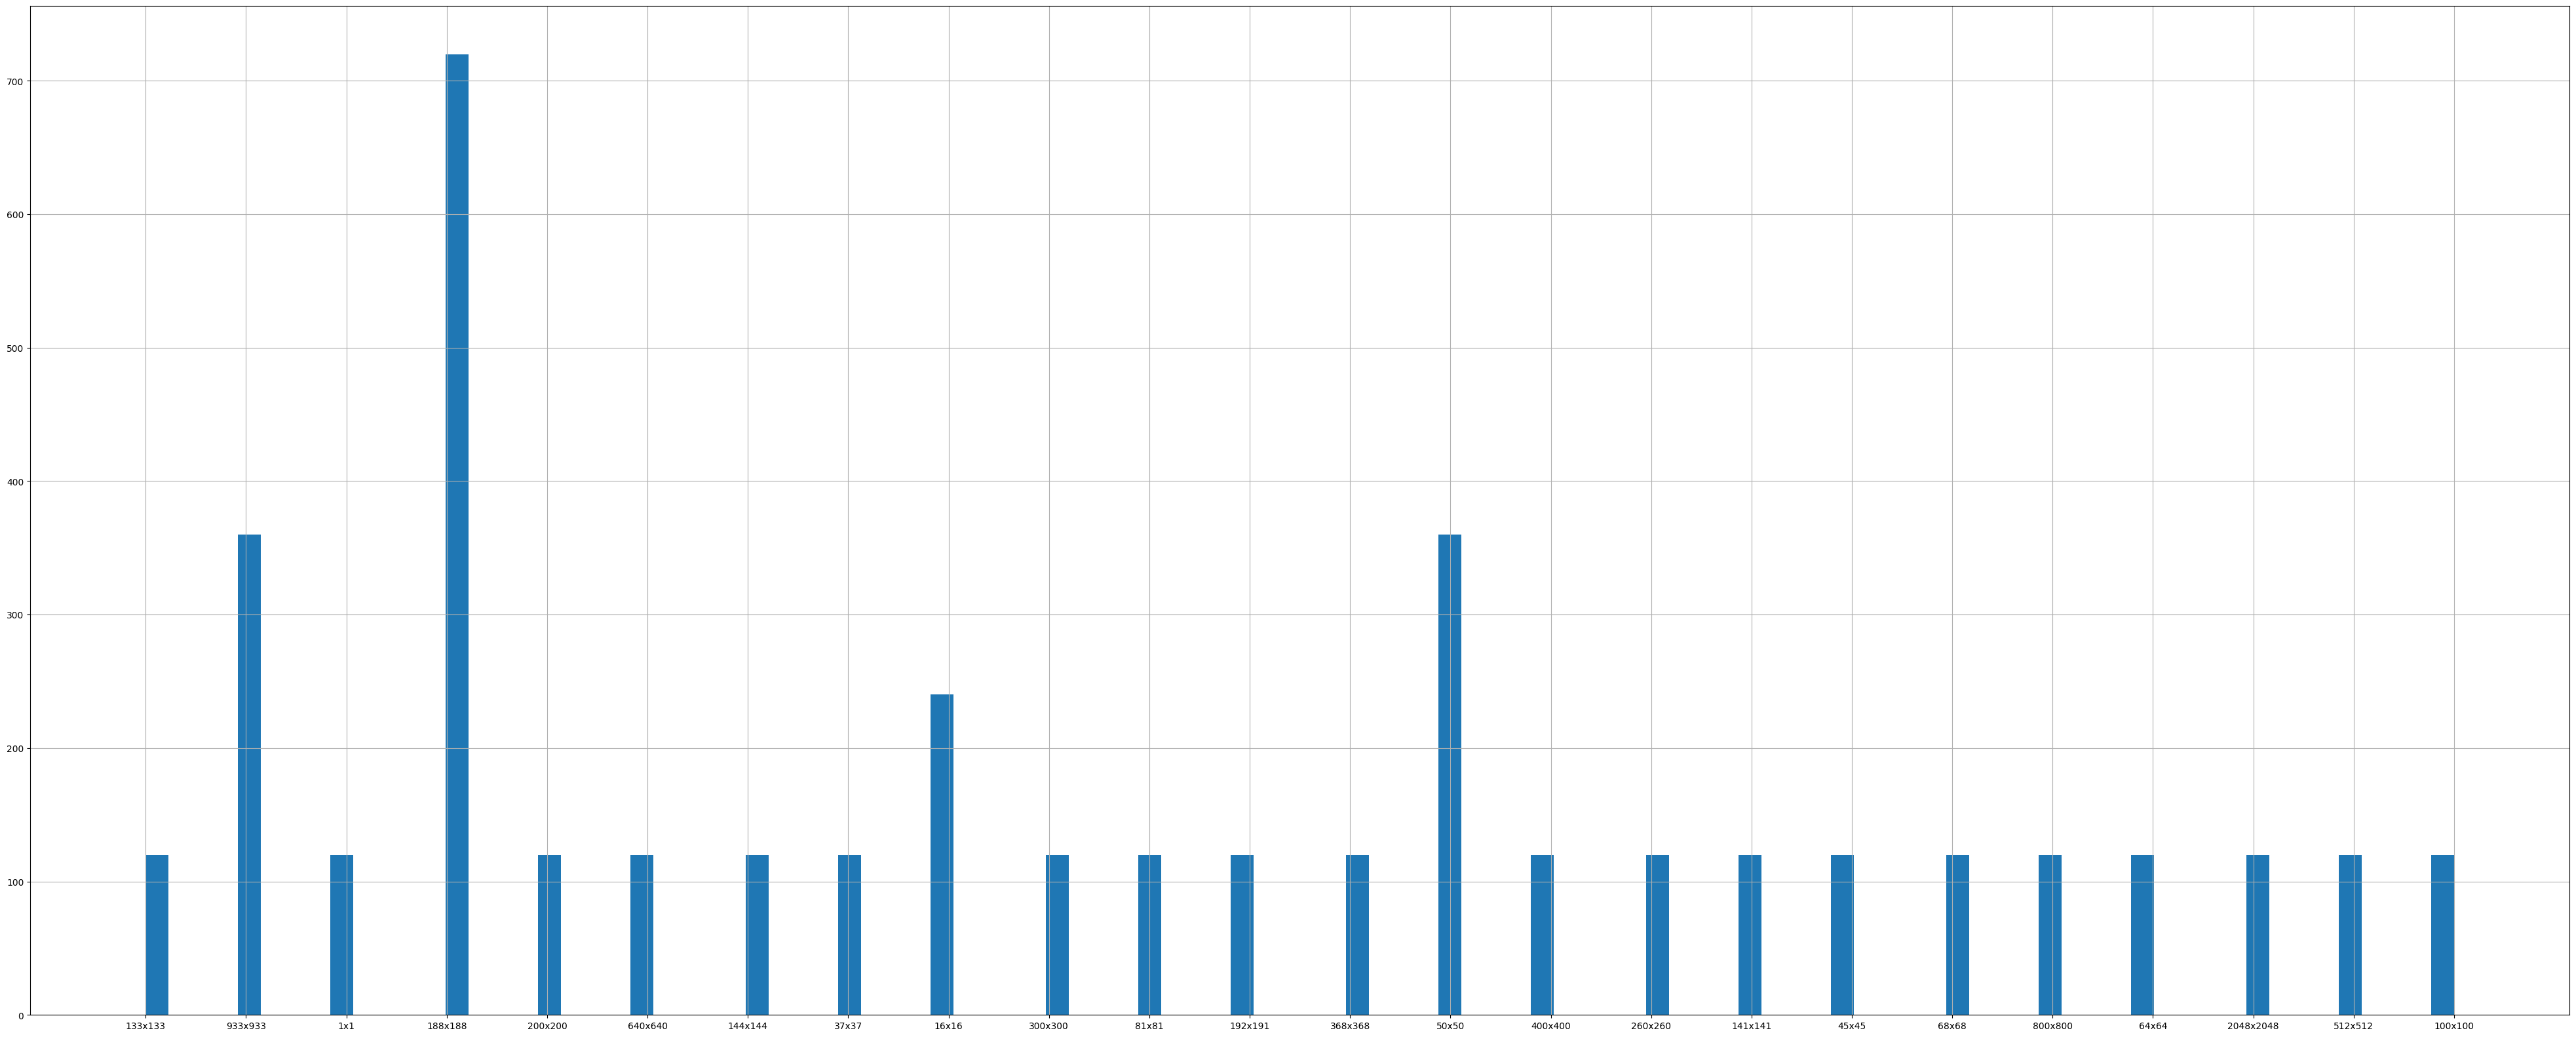

In [62]:
#pieces["Dimension"].loc[(pieces["Piece"] == "Pawn")].hist(figsize=(50,20), bins=50)
pieces["Dimension"].hist(figsize=(50,20), bins=100)

As we can see we have some troubles here. First of all some of the images have dimensionality 1X1, then the remaing dimensionalites range from 16x16 to 2048x2048.

CNN works by training and testing on images that have the same dimensionality so we need to make some adjustments.

I think i'll do the following steps:
- Delete all the 1x1 dimensionality instances
- Choose a dimensionality threshold and delete all the instances whose dimensionality < or > threshold
- Scale all the images to have the same dimensionality

I run a test by screenshotting some chess positions from youtube, lichess and chess.com and the resulting resolutions are:
- lichess.org: 704x711
- chess.com: 868x876
- youtube fullscreen: 1062x1060
- youtube ***not*** fullscreen: 681x697

From which we get, more or less depending on the quality of the screenshot taken, the following ***single cell resolutions***:
- lichess.org: 88x88
- chess.com: 110x110
- youtube fullscreen: 132x130
- youtube ***not*** fullscreen: 82x86

## Changing the pieces dimensionality related to the test size

The main idea is that i need to have a screenshot whose single cell dimensionality matches the dimensionality of the pieces i trained on. Therefore i need to make the pieces all the same dimension, then multiply each dimension by 8. **This result will be the dimensionality i need to set my screenshot to**, so that by diving it into 64 squared, each and every one of it will match the pieces size.

1. random piece width = x, random piece height = y
2. scaled fixed piece width = x', scaled fixed piece height = y'
3. scaled screenshot width = x' * 8, scaled screenshot height = y' * 8